# Work dir

In [1]:
pwd

u'/SNS/users/lj7/notebooks/.rk-work/jnrk-sns-analysis-python2-default'

In [4]:
workdir = "/SNS/users/lj7/reduction/SEQ/17106/"

In [6]:
mkdir -p {workdir}

In [7]:
cd {workdir}

/SNS/users/lj7/reduction/SEQ/17106


# Utils

In [8]:
import  mantid.simpleapi as msa

In [9]:
import glob, os, numpy as np

In [10]:
from matplotlib import pyplot as plt

In [11]:
%matplotlib notebook

# Data inputs

In [12]:
dir = "/SNS/SEQ/IPTS-17106/nexus/"

In [13]:
dir

'/SNS/SEQ/IPTS-17106/nexus/'

In [18]:
files1 = [os.path.join(dir, 'SEQ_%s.nxs.h5' % r) for r in range(117510,117594)]

In [17]:
ls -l {files1[0]}

-rw-rw-r-- 1 snsdata adara 57836671 Dec  1 05:46 /SNS/SEQ/IPTS-17106/nexus/SEQ_117510.nxs.h5


In [19]:
files2 = [os.path.join(dir, 'SEQ_%s.nxs.h5' % r) for r in range(117602,117608)]

In [20]:
files = files1 + files2

In [21]:
len(files)

90

# Analysis

### Load data

In [22]:
ws = msa.Load(','.join(files))

### Get t0

In [27]:
mon = msa.LoadNexusMonitors("SEQ_117520")

In [32]:
Ei,t0 = msa.GetEiT0atSNS(mon, 75)

In [33]:
print Ei, t0

74.853416482 35.1202165008


### Shift all of the time-of-flights by the t0 value just determined


In [34]:
ws = msa.ChangeBinOffset(ws,-t0)

### TOF window?

In [35]:
ws[0]

EventWorkspace
Title: NCMIstrainglass, T=300K, Ei75 Fch1=240, T0=60
Histograms: 115712
Bins: 1
Histogram
X axis: Time-of-flight / microsecond
Y axis: Counts
Distribution: False
Instrument: SEQUOIA (2012-Apr-04 to 2100-Jan-31)Instrument from: /SNS/SEQ/IPTS-17106/nexus/SEQ_117510.nxs.h5

Parameters from: /SNS/software/miniconda2/envs/py2/instrument/SEQUOIA_Parameters.xml
Run start: 2016-Dec-01 10:39:58
Run end:  2016-Dec-01 10:46:42

Events: 1592053

In [36]:
tofhist = msa.Rebin(InputWorkspace=ws[0], OutputWorkspace='tofws', Params="1000,100,10000")

In [37]:
stofhist = msa.SumSpectra(InputWorkspace='tofws', OutputWorkspace='stofws')

In [38]:
stofhist.getNumberHistograms()

1

In [39]:
tof = stofhist.extractX()[0]

In [40]:
tof.size

91

In [41]:
tof.shape

(91,)

In [42]:
tof1 = (tof[:-1]+tof[1:])/2

In [43]:
I = stofhist.extractY()[0]

<IPython.core.display.Javascript object>


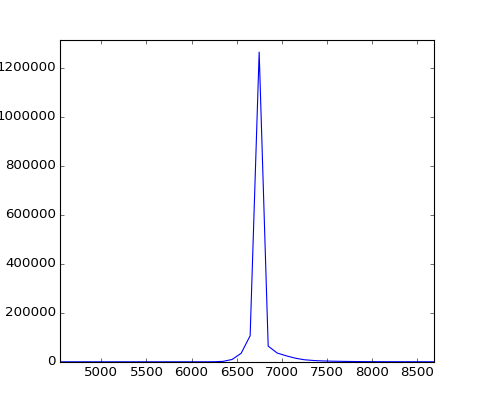

In [44]:
plt.plot(tof1, I)

In [45]:
ws = msa.CropWorkspace(ws,XMin='6200',XMax='7700')

### Set goniometer so that mantid know where to get psi angle

In [46]:
msa.SetGoniometer(Workspace='ws', Axis0='phi,0,1,0,1')

### Convert to Q coordinates. still events

In [47]:
mdparts = msa.ConvertToMD(
    InputWorkspace=ws,
    dEAnalysisMode="Elastic",
    QDimensions='Q3D',
    Q3DFrames="Q_sample",
    MinValues="-12,-12,-12,-20",
    MaxValues="12,12,12,20")

In [48]:
msa.DeleteWorkspace('ws')

In [49]:
mdmerged = msa.MergeMD(InputWorkspaces='mdparts', OutputWorkspace='mdmerged')

In [50]:
msa.DeleteWorkspace('mdparts')

In [51]:
# mdmerged

In [ ]:
msa.BinMD(InputWorkspace='mdmerged', OutputWorkspace='slice', 
          AlignedDim0='Q_sample_y,-10,10,200', 
          AlignedDim1='Q_sample_z,-10,10,200',
          AlignedDim2='Q_sample_x,-0.5,0.5,1',
         )

In [204]:
slice = msa.mtd['slice']

In [209]:
d = slice.getSignalArray()*1.0

In [210]:
d.shape = 200,200

<IPython.core.display.Javascript object>


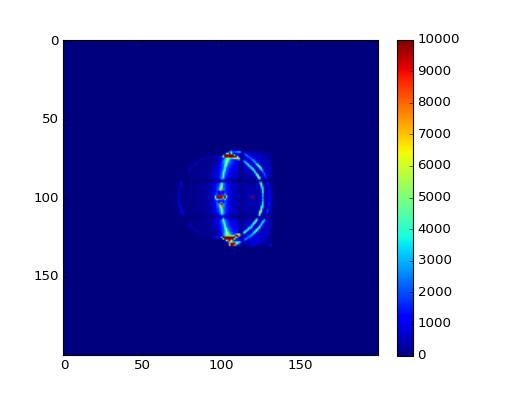

In [213]:
plt.imshow(d)
plt.clim(0,10000)
plt.colorbar()

### Set approximate lattice params and u/v

In [52]:
a = 5.98
msa.SetUB(mdmerged, a=a, b=a, c=a, alpha=90, beta=90, gamma=90, u="1.,1.,0.", v="0,0,1")

### Find peaks

In [53]:
peaks=msa.FindPeaksMD(InputWorkspace='mdmerged', PeakDistanceThreshold=0.7, DensityThresholdFactor=1000, OutputWorkspace='peaks')

In [56]:
peaks.getNumberPeaks()

633

In [54]:
pk0 = peaks.getPeak(0)

In [55]:
pk0.getQSampleFrame()

[2.14383,-0.0955245,0.0112773]

#### Peaks not indexed yet

In [57]:
pk0.getHKL()

[0,0,0]

### Index peaks

In [61]:
msa.IndexPeaks(PeaksWorkspace='peaks',  Tolerance=0.25)

(340, 0.0006032500255748604)

In [62]:
pk0.getHKL()

[0,0,0]

### Remove peaks not indexed (is this necessary?)

In [63]:
for index in range(peaks.getNumberPeaks()-1, -1, -1):
    p = peaks.getPeak(index)
    if np.allclose(p.getHKL(), [0,0,0]):
        peaks.removePeak(index)

In [64]:
peaks.getNumberPeaks()

327

### Calculate U matrix

In [65]:
msa.CalculateUMatrix(peaks, a=a, b=a, c=a, alpha=90, beta=90, gamma=90)

In [66]:
ol = peaks.sample().getOrientedLattice()
ol.getuVector(), ol.getvVector()

([4.41368,4.03439,0.0595232], [0.114631,-0.213564,5.97509])

In [67]:
ol.getUB()

array([[ 0.00320552, -0.00597207,  0.16708666],
       [ 0.11278399, -0.12329028, -0.00657043],
       [ 0.12342361,  0.11281726,  0.0016645 ]])

### Optimize lattice parameters

In [68]:
msa.OptimizeLatticeForCellType(peaks,CellType="Cubic")

0.000645013558695903

In [69]:
ol = peaks.sample().getOrientedLattice()
ol.getuVector(), ol.getvVector()

([4.41758,4.03796,0.0595758], [0.114732,-0.213753,5.98037])

In [70]:
print ol.a1(), ol.a2(), ol.a3()

5.98528767688 5.98528767688 5.98528767688


In [71]:
print ol.alpha(), ol.beta(), ol.gamma()

90.0 90.0 90.0


In [72]:
print peaks.sample().getOrientedLattice().getUB()

[[ 0.00320269 -0.0059668   0.16693905]
 [ 0.11268435 -0.12318136 -0.00656462]
 [ 0.12331458  0.11271759  0.00166303]]


# Validation

In [73]:
msa.IndexPeaks(peaks,RoundHKLs=0, Tolerance=0.25)

(320, 0.00030248870616628404)

In [74]:
peaks.getPeak(0).getHKL()

[0.997579,-0.99008,1.00125]

In [76]:
maxdiff = 0
for pk in peaks:
    hkl = [pk['h'], pk['k'], pk['l']]
    hkl0 = np.round(hkl)
    diff = hkl0 - hkl
    diff = np.linalg.norm(diff)
    if diff > maxdiff: maxdiff = diff
    print hkl0, hkl
    continue
print maxdiff

[ 1. -1.  1.] [0.9975789010128755, -0.9900797606146364, 1.0012489334373358]
[ 2.  2. -4.] [2.0942419915407258, 2.0139183889297354, -3.9831741671529155]
[-0. -0.  2.] [-0.030340868283237052, -0.019496894138133335, 2.0233523828576487]
[ 1. -1.  1.] [0.9471646445547353, -1.0475360077039617, 1.0073746206412981]
[-0.  2. -4.] [-0.054796950725566396, 1.9545995471529618, -3.9827928430902033]
[ 2.  2. -4.] [2.028379273002935, 2.021632448995057, -4.0135198465891495]
[ 2.  0. -4.] [1.9980384047196975, 0.0021355548569240773, -3.990167463731501]
[ 0.  0.  2.] [0.01738373591734063, 0.01548119032592181, 2.01271083068914]
[ 1. -1.  1.] [0.9652325281653191, -1.030962380651844, 0.9745783386217167]
[-0.  2. -4.] [-0.017383735917340513, 1.9845188096740785, -4.012710830689143]
[ 2.  0. -4.] [2.0173837359173405, 0.015481190325921735, -3.9872891693108587]
[-0. -0.  2.] [-0.010283020593671617, -0.0009882540188347185, 2.0552901494490143]
[-0. -0.  2.] [-0.010183261366788637, -0.00317847745066401, 2.0439563393